In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import re

In [93]:
df=pd.read_excel("todos.xlsx")
df2=pd.read_excel("com1.xlsx")

In [263]:
scaler=MinMaxScaler()
df["fullname"]=df["Nombre"] + df["Apellido(s)"]
df2["fullname"]=df2["Nombre"] + df2["Apellido(s)"]
df["hash"]=df.fullname.map(lambda x: hash(x))
df2["hash"]=df2.fullname.map(lambda x: hash(x))
parcial_com1=pd.concat([df[df.hash==code] for code in df2.hash])
parcial_com1=parcial_com1.iloc[:,~parcial_com1.replace({"-":np.nan}).isnull().all().values[..., np.newaxis]].copy()
parcial_com1.drop(columns=['Nombre', 'Apellido(s)', 'Número de ID', 'Dirección de correo','Total del curso (Real)', 'Última descarga de este curso', 'fullname'], inplace=True)
parcial_com1.replace("-","0", inplace=True)
evaluaciones_com1=df2.iloc[:,~df2.replace({"-":np.nan}).isnull().all().values[..., np.newaxis]].copy()
evaluaciones_com1.drop(columns=['Nombre', 'Apellido(s)', 'Número de ID', 'Dirección de correo','Total del curso (Real)', 'Última descarga de este curso', 'fullname'], inplace=True)
evaluaciones_com1.replace("-","0", inplace=True)
datacols=[col for col in evaluaciones_com1 if "hash" not in col]
data_evs=scaler.fit_transform(evaluaciones_com1[datacols])
todas_evs_c1=pd.DataFrame(data=data_evs, index=evaluaciones_com1.hash,columns=datacols)
ev_control=todas_evs_c1.loc[:,[col for col in todas_evs_c1.columns if "Control" in col]]
datacols_p=[col for col in parcial_com1 if "hash" not in col]
data_parc=scaler.fit_transform(parcial_com1[datacols_p])
parcial_c1=pd.DataFrame(data=data_parc, index=parcial_com1.hash,columns=datacols_p)

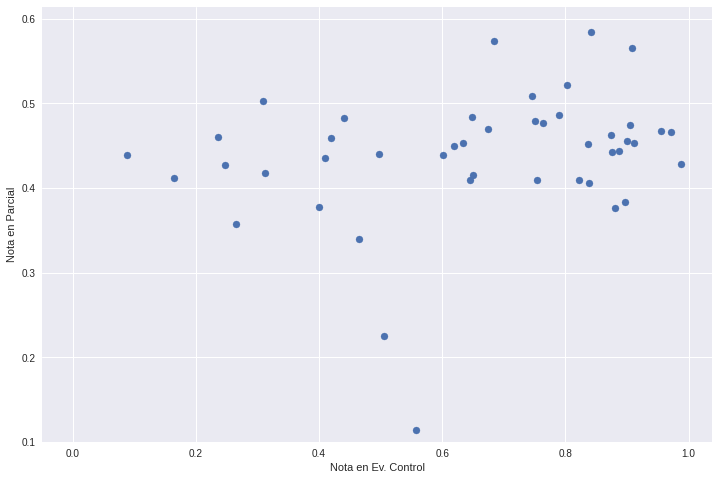

In [276]:
sorted_p1=parcial_c1.sort_index()
sorted_ctrl=ev_control.sort_index()
sorted_ctrl.drop(columns='CuestionarioControl:Equilibrio Iónico - pH e hidrólisis (Real)', inplace=True)
# sorted_ctrl=todas_evs_c1.sort_index()
plt.style.use("seaborn")
plt.figure(figsize=(12,8))
plt.scatter(sorted_ctrl.mean(axis=1) ,sorted_p1.mean(axis=1))
plt.xlabel("Nota en Ev. Control")
plt.ylabel("Nota en Parcial")
plt.ylim(bottom=.1)
plt.savefig("Notas.png")

In [277]:
sorted_ctrl=sorted_ctrl.rename(columns={
    'Cuestionario:Cuestionario Control 1 (Real)':"T1",
       'Cuestionario:Evaluación de Control (Real)':"T2",
       'Cuestionario:Evaluación de Control: Cinética Química y Equilibrio Químico (Real)':"T3"
})


In [278]:
patron=re.compile(r"(?<=Cuestionario\:)(\w\d)*")
sorted_p1.columns=[re.search(patron, name).group() for name in sorted_p1.columns]

In [279]:
def mejor_nota(df):
    a=df[df.columns[1::2]].max(axis=1)
    b=df[df.columns[::2]].max(axis=1)
    return pd.concat((a,b), axis=1,names=("parte1","parte2"))

In [283]:
temas=[sorted_p1[[col for col in sorted_p1.columns if col_c in col]] for col_c in sorted_ctrl.columns ]
temas=[ mejor_nota(tema) for tema in temas]
temas=[tema.join(sorted_ctrl[evc], on="hash", how="right") for tema, evc in zip(temas, sorted_ctrl.columns)]

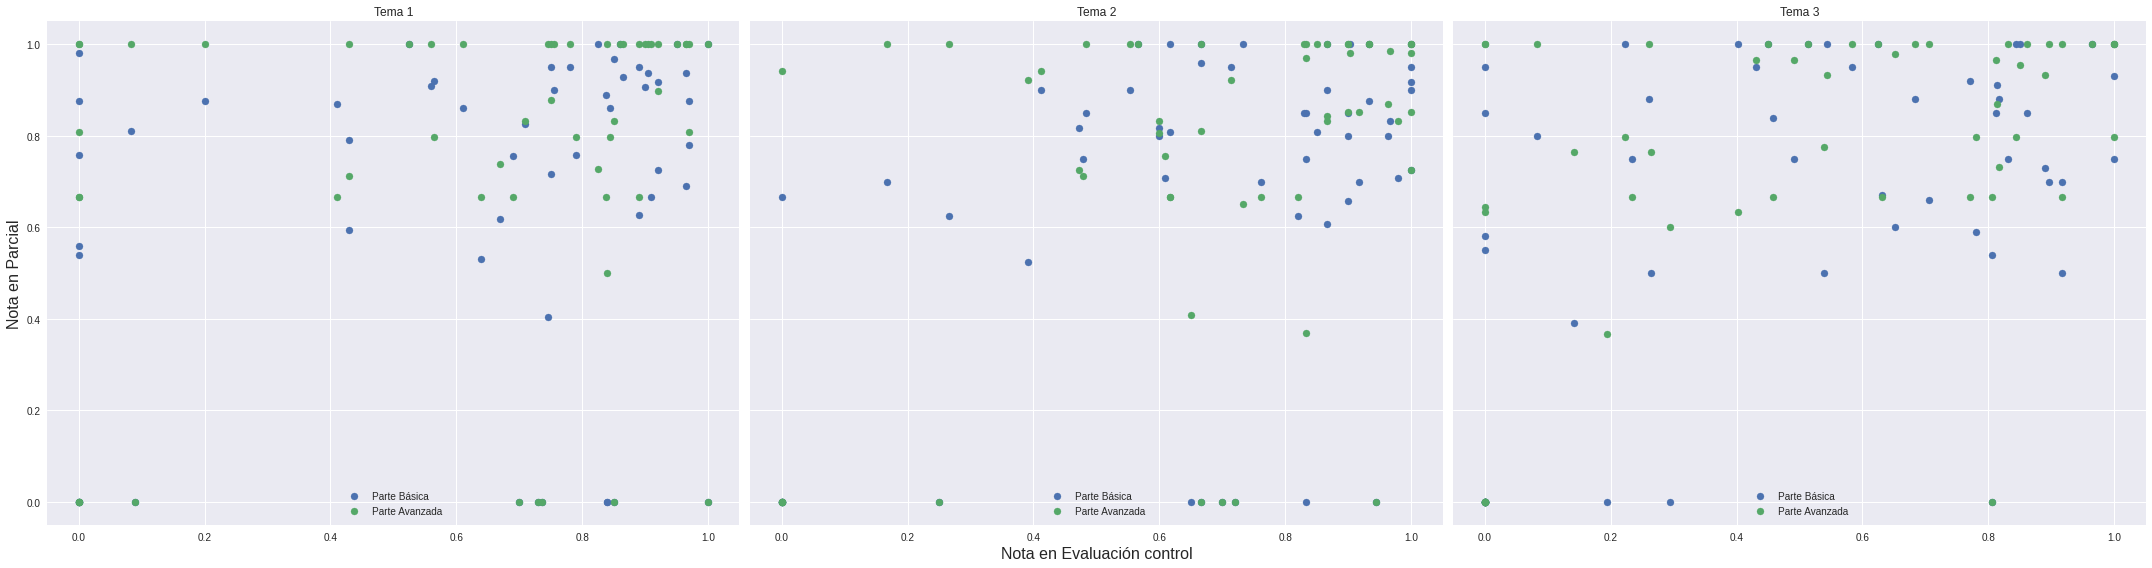

In [282]:

fig,ax=plt.subplots(nrows=1,ncols=3, figsize=(30,8), sharey=True)
ax=ax.flatten()
for n,tema in enumerate(temas):
    ax[n].scatter(tema.iloc[:,-1], tema.iloc[:,:-1][0], label="Parte Básica")
    ax[n].scatter(tema.iloc[:,-1], tema.iloc[:,:-1][1], label="Parte Avanzada")
    ax[n].set_title("Tema {}".format(tema.iloc[:,-1].name[-1]))
    ax[1].set_xlabel("Nota en Evaluación control", fontsize=16)
    ax[0].set_ylabel("Nota en Parcial", fontsize=16)
    ax[n].legend(loc='lower center')
plt.tight_layout()
plt.savefig("disgregado_por_tema.png")